In [0]:
!pip install -U -q PyDrive
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import os, re, csv, logging, string
import pandas as pd
import seaborn as sns
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# read data from a csv file    
def read_csv (filename, logout = True):
	try:
		reader = csv.reader(open(filename, "r"))
		data = []
		for r in reader:
			data.append(r)
		return data
	except Exception as e:
		if logout is True:
			logging.error(e)
		return None
  
# write data in format of [(x1,y1,z1),(x2,y2,z2)] to a csv file
def write_csv (filename, data, logout = True):
	try:
		doc = csv.writer (open(filename, 'w'), delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
		for d in data:
			doc.writerow (d)
		return True			
	except Exception as e:
		if logout is True:
			log.error(e)
		return False

# remove punctuation
def trans(s):
  exclude = string.punctuation
  return s.translate(str.maketrans({key: None for key in exclude}))

# chunk list to approximatly equal parts
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

# calculate cosine similarity in 10*10 2D array
def tfidf_cosine_sim(model):
    l = []
    sim = []
    for x in range(model.shape[0]):
        l.append(x)
    for m in (l[:10]):
        for n in (l[10:]):
            sim.append(cosine_similarity(model[m], model[n])[0][0])
    return sim

# rank cosine similarity
def rank_question_similarities(model, corpus, corpus_i):
    cos = []
    for x in range(model.shape[0]):
        sim = cosine_similarity(model[0], model[x])
        cos.append([corpus_i[x], corpus[x], sim[0][0]])
    return cos

# calculate cosine similarity under Universal Sentence Encoder
def get_UniSentEnc_sim(corpus, corpus_i):
  module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
  embed = hub.Module(module_url)
  init = tf.global_variables_initializer()
  table_init = tf.tables_initializer()
  with tf.Session() as sess:
    sim = []
    sess.run([init, table_init])
    similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
    encoding_tensor = embed(similarity_input_placeholder)
    for f in range(len(corpus)):
      en_embeddings_1 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: [corpus[0]]})
      en_embeddings_2 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: [corpus[f]]})
      sim.append([corpus_i[f], corpus[f], float(cosine_similarity(en_embeddings_1, en_embeddings_2))])
  return sim


# calculate cosine similarity of ELmo
def get_elmo_sim(corpus, corpus_i):
  elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
  init = tf.global_variables_initializer()
  table_init = tf.tables_initializer()
  with tf.Session() as sess:
    sim = []
    sess.run([init, table_init])
    similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
    encoding_tensor = elmo(similarity_input_placeholder)
    for f in range(len(corpus)):
      en_embeddings_1 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: [corpus[0]]})
      en_embeddings_2 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: [corpus[f]]})
      sim.append([corpus_i[f], corpus[f], float(cosine_similarity(en_embeddings_1, en_embeddings_2))])
  return sim

In [0]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# load data
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine_lab.csv')
creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q1.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q2.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q3.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q4.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q5.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q6.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q7.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q8.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q9.csv')
#creatinine_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/creatinine/creatinine_Q10.csv')

#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c_lab.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q1.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q2.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q3.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q4.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q5.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q6.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q7.csv')
hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q8.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q9.csv')
#hba1c_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/hba1c/hba1c_Q10.csv')

#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose_lab.csv')
glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q1.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q2.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q3.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q4.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q5.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q6.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q7.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q8.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q9.csv')
#glucose_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/glucose/glucose_Q10.csv')

#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q1.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q2.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q3.csv')
noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q4.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q5.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q6.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q7.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q8.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q9.csv')
#noLab_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/noLab/noLab_Q10.csv')

creatinine_id = [d[0] for d in creatinine_d]
hba1c_id = [d[0] for d in hba1c_d]
glucose_id = [d[0] for d in glucose_d]
noLab_id = [d[0] for d in noLab_d]

creatinine = [d[1].lower() for d in creatinine_d]
hba1c = [d[1].lower() for d in hba1c_d]
glucose = [d[1].lower() for d in glucose_d]
noLab = [d[1].lower() for d in noLab_d]

#creatinine_exp = [d[4] for d in creatinine_d]
#hba1c_exp = [d[4] for d in hba1c_d]
#glucose_exp = [d[4] for d in glucose_d]

# remove punctuation
creatinine_np = [trans(c) for c in creatinine]
hba1c_np = [trans(c) for c in hba1c]
glucose_np = [trans(c) for c in glucose]
noLab_np = [trans(c) for c in noLab]

# tokenization
creatinine_token = [word_tokenize(c) for c in creatinine_np]
hba1c_token = [word_tokenize(c) for c in hba1c_np]
glucose_token = [word_tokenize(c) for c in glucose_np]
noLab_token = [word_tokenize(c) for c in noLab_np]

# remove stopwords
words_stop = [str(c) for c in stopwords.words('english')]
creatinine_no_stopw = [[cc for cc in c if cc not in words_stop]for c in creatinine_token]
hba1c_no_stopw = [[cc for cc in c if cc not in words_stop]for c in hba1c_token]
glucose_no_stopw = [[cc for cc in c if cc not in words_stop]for c in glucose_token]
noLab_no_stopw = [[cc for cc in c if cc not in words_stop]for c in noLab_token]

# stemming words
ps = nltk.stem.PorterStemmer()
creatinine_stemw = [[str(ps.stem(s)) for s in sw] for sw in creatinine_no_stopw]
hba1c_stemw = [[str(ps.stem(s)) for s in sw] for sw in hba1c_no_stopw]
glucose_stemw = [[str(ps.stem(s)) for s in sw] for sw in glucose_no_stopw]
noLab_stemw = [[str(ps.stem(s)) for s in sw] for sw in noLab_no_stopw]

# convert tokens back to sentence
creatinine_stemw_s = [' '.join(i) for i in creatinine_stemw]
hba1c_stemw_s = [' '.join(i) for i in hba1c_stemw]
glucose_stemw_s = [' '.join(i) for i in glucose_stemw]
noLab_stemw_s = [' '.join(i) for i in noLab_stemw]

# vectorize using tfidf
vectorizer = TfidfVectorizer(min_df=1)
C = vectorizer.fit_transform(creatinine_stemw_s)
H = vectorizer.fit_transform(hba1c_stemw_s)
G = vectorizer.fit_transform(glucose_stemw_s)
N = vectorizer.fit_transform(noLab_stemw_s)

#out = rank_question_similarities(C, creatinine, creatinine_id)
#out = rank_question_similarities(H, hba1c, hba1c_id)
#out = rank_question_similarities(G,glucose, glucose_id)
#out = rank_question_similarities(N,noLab, noLab_id)
#write_csv('/content/drive/My Drive/Thesis_feature_sim/test.csv', out)

True

In [0]:
# Universal Sentence Encoder: calculate cosine similarity
#sim = get_UniSentEnc_sim(creatinine, creatinine_id)
#sim = get_UniSentEnc_sim(hba1c, hba1c_id)
#sim = get_UniSentEnc_sim(glucose, glucose_id)
#sim = get_UniSentEnc_sim(noLab, noLab_id)

# ELMo: caculate cosine similarity
#sim = get_elmo_sim(creatinine, creatinine_id)
sim = get_elmo_sim(hba1c, hba1c_id)
#sim = get_elmo_sim(glucose, glucose_id)
#sim = get_elmo_sim(noLab, noLab_id)

write_csv('/content/drive/My Drive/Thesis_feature_sim/test.csv', sim)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


True

In [0]:
# load mixed data
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q1.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q2.csv')
hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q3.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q4.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q5.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q6.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q7.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q8.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q9.csv')
#hba1c_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/HbA1c_top10mix_Q10.csv')

#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q1.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q2.csv')
noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q3.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q4.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q5.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q6.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q7.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q8.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q9.csv')
#noLab_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/NoLab_top10mix_Q10.csv')

#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q1.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q2.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q3.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q4.csv')
glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q5.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q6.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q7.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q8.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q9.csv')
#glucose_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Glucose_top10mix_Q10.csv')

#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q1.csv')
creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q2.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q3.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q4.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q5.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q6.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q7.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q8.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q9.csv')
#creatinine_mix_d = read_csv('/content/drive/My Drive/Thesis_feature_sim/mix_csv/Creatinine_top10mix_Q10.csv')

# extract id
hba1c_mix_id = [d[0] for d in hba1c_mix_d]
noLab_mix_id = [d[0] for d in noLab_mix_d]
glucose_mix_id = [d[0] for d in glucose_mix_d]
creatinine_mix_id = [d[0] for d in creatinine_mix_d]

# extract question and convert to lowercase
hba1c_mix = [d[1].lower() for d in hba1c_mix_d]
noLab_mix = [d[1].lower() for d in noLab_mix_d]
glucose_mix = [d[1].lower() for d in glucose_mix_d]
creatinine_mix = [d[1].lower() for d in creatinine_mix_d]

# remove punctuation
hba1c_mix_np = [trans(c) for c in hba1c_mix]
noLab_mix_np = [trans(c) for c in noLab_mix]
glucose_mix_np = [trans(c) for c in glucose_mix]
creatinine_mix_np = [trans(c) for c in creatinine_mix]

# tokenization
hba1c_mix_token = [word_tokenize(c) for c in hba1c_mix_np]
noLab_mix_token = [word_tokenize(c) for c in noLab_mix_np]
glucose_mix_token = [word_tokenize(c) for c in glucose_mix_np]
creatinine_mix_token = [word_tokenize(c) for c in creatinine_mix_np]

# remove stopwords
words_stop = [str(c) for c in stopwords.words('english')]
hba1c_mix_no_stopw = [[cc for cc in c if cc not in words_stop]for c in hba1c_mix_token]
noLab_mix_no_stopw = [[cc for cc in c if cc not in words_stop]for c in noLab_mix_token]
glucose_mix_no_stopw = [[cc for cc in c if cc not in words_stop]for c in glucose_mix_token]
creatinine_mix_no_stopw = [[cc for cc in c if cc not in words_stop]for c in creatinine_mix_token]

# stemming words
ps = nltk.stem.PorterStemmer()
hba1c_mix_stemw = [[str(ps.stem(s)) for s in sw] for sw in hba1c_mix_no_stopw]
noLab_mix_stemw = [[str(ps.stem(s)) for s in sw] for sw in noLab_mix_no_stopw]
glucose_mix_stemw = [[str(ps.stem(s)) for s in sw] for sw in glucose_mix_no_stopw]
creatinine_mix_stemw = [[str(ps.stem(s)) for s in sw] for sw in creatinine_mix_no_stopw]

# convert tokens back to sentence
hba1c_mix_stemw_s = [' '.join(i) for i in hba1c_mix_stemw]
noLab_mix_stemw_s = [' '.join(i) for i in noLab_mix_stemw]
glucose_mix_stemw_s = [' '.join(i) for i in glucose_mix_stemw]
creatinine_mix_stemw_s = [' '.join(i) for i in creatinine_mix_stemw]

# vectorize using tfidf
vectorizer = TfidfVectorizer(min_df=1)
Hm = vectorizer.fit_transform(hba1c_mix_stemw_s)
Nm = vectorizer.fit_transform(noLab_mix_stemw_s)
Gm = vectorizer.fit_transform(glucose_mix_stemw_s)
Cm = vectorizer.fit_transform(creatinine_mix_stemw_s)

#out = rank_question_similarities(Hm, hba1c_mix, hba1c_mix_id)
#out = rank_question_similarities(Nm,noLab_mix, noLab_mix_id)
out = rank_question_similarities(Gm,glucose_mix, glucose_mix_id)
#out = rank_question_similarities(Cm,creatinine_mix, creatinine_mix_id)
write_csv('/content/drive/My Drive/Thesis_feature_sim/test.csv', out)

True

In [0]:
# Universal Sentence Encoder: calculate cosine similarity
#sim = get_UniSentEnc_sim(hba1c_mix, hba1c_mix_id)
#sim = get_UniSentEnc_sim(noLab_mix, noLab_mix_id)
#sim = get_UniSentEnc_sim(glucose_mix, glucose_mix_id)
#sim = get_UniSentEnc_sim(creatinine_mix, creatinine_mix_id)

# ELMo: caculate cosine similarity
sim = get_elmo_sim(hba1c_mix, hba1c_mix_id)
#sim = get_elmo_sim(noLab_mix, noLab_mix_id)
#sim = get_elmo_sim(glucose_mix, glucose_mix_id)
#sim = get_elmo_sim(creatinine_mix, creatinine_mix_id)

write_csv('/content/drive/My Drive/Thesis_feature_sim/test.csv', sim)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


True

In [0]:
lns = min_max_normalization(get_len(creatinine))
num_q = [n for n in num_of_q_mark(creatinine)]
n_stopw = count_stopword(creatinine)
wh = min_max_normalization(count_WH_question(creatinine))
kars = []
n_noun = num_of_noun(creatinine)
n_vb = num_of_verb(creatinine)
n_adj = num_of_adj(creatinine)

out = list(zip(lns, num_q, n_stopw, wh, n_noun, n_vb, n_adj))
d_d = pd.DataFrame(out, columns=['Sentence length', 'number of \'?\'', 'Stopword count', 
                               'WH question type', 'Number of nouns', 'Number of verbs', 
                               'Number of adjectives'])
#d_d.to_csv('/content/drive/My Drive/Thesis_feature_sim/test.csv', index=False)

In [0]:
lth = [(1 - abs(d_d['Sentence length'][0] - x)) for x in d_d['Sentence length']]
qmark = [(1 - abs(d_d['number of \'?\''][0] - x)) for x in d_d['number of \'?\'']]
sword = [(1 - abs(d_d['Stopword count'][0] - x)) for x in d_d['Stopword count']]
wh_q = [(1 - abs(d_d['WH question type'][0] - x)) for x in d_d['WH question type']]
n_noun = [(1 - abs(d_d['Number of nouns'][0] - x)) for x in d_d['Number of nouns']]
n_vb = [(1 - abs(d_d['Number of verbs'][0] - x)) for x in d_d['Number of verbs']]
n_adj = [(1 - abs(d_d['Number of adjectives'][0] - x)) for x in d_d['Number of adjectives']]
out = list(zip(lns, num_q, n_stopw, wh, n_noun, n_vb, n_adj))
df = pd.DataFrame(out, columns=['Sentence length', 'number of \'?\'', 'Stopword count', 
                               'WH question type', 'Number of nouns', 'Number of verbs', 
                               'Number of adjectives'])
df.to_csv('/content/drive/My Drive/Thesis_feature_sim/test.csv', index=False)

In [0]:
nl1 = ['Can you live a long life with type 2 diabetes?']
nl2 = ['how long can you live with diabetes 2']

# remove punctuation
nl1_np = [trans(c) for c in nl1]
nl2_np = [trans(c) for c in nl2]

# tokenization
nl1_token = [word_tokenize(c) for c in nl1_np]
nl2_token = [word_tokenize(c) for c in nl2_np]

# remove stopwords
words_stop = [str(c) for c in stopwords.words('english')]
nl1_no_stopw = [[cc for cc in c if cc not in words_stop]for c in nl1_token]
nl2_no_stopw = [[cc for cc in c if cc not in words_stop]for c in nl2_token]

# stemming words
ps = nltk.stem.PorterStemmer()
nl1_stemw = [[str(ps.stem(s)) for s in sw] for sw in nl1_no_stopw]
nl2_stemw = [[str(ps.stem(s)) for s in sw] for sw in nl2_no_stopw]

# convert tokens back to sentence
nl1_stemw_s = [' '.join(i) for i in nl1_stemw]
nl2_stemw_s = [' '.join(i) for i in nl2_stemw]

print(nl1_stemw_s, nl2_stemw_s)

"""
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url)
init = tf.global_variables_initializer()
table_init = tf.tables_initializer()
with tf.Session() as sess:
  sim = []
  sess.run([init, table_init])
  similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
  encoding_tensor = embed(similarity_input_placeholder)
  en_embeddings_1 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: nl1_stemw_s})
  en_embeddings_2 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: nl2_stemw_s})
  print(float(cosine_similarity(en_embeddings_1, en_embeddings_2)))
  """

['can live long life type 2 diabet'] ['long live diabet 2']


'\nmodule_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]\nembed = hub.Module(module_url)\ninit = tf.global_variables_initializer()\ntable_init = tf.tables_initializer()\nwith tf.Session() as sess:\n  sim = []\n  sess.run([init, table_init])\n  similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))\n  encoding_tensor = embed(similarity_input_placeholder)\n  en_embeddings_1 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: nl1_stemw_s})\n  en_embeddings_2 = sess.run(encoding_tensor, feed_dict={similarity_input_placeholder: nl2_stemw_s})\n  print(float(cosine_similarity(en_embeddings_1, en_embeddings_2)))\n  '

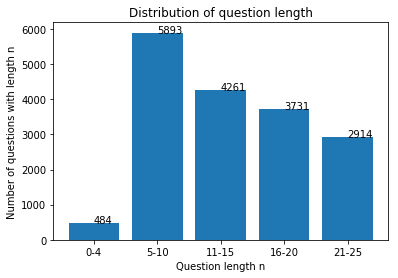

In [0]:
qlen = []
qqlen = read_csv('/content/drive/My Drive/Thesis_feature_sim/length_all_question.csv')

for q in qqlen:qlen.append(q[2])

wu = []
shi = []
shiwu = []
ershi = []
erwu = []
dayu_erwu = []
for q in qlen:
  if 0 < int(q) <= 4:
    wu.append(int(q))
  elif 5 <= int(q) <= 10:
    shi.append(int(q))
  elif 11 <= int(q) <= 15:
    shiwu.append(int(q))
  elif 16 <= int(q) <= 20:
    ershi.append(int(q))
  elif 20 < int(q) <= 25:
    erwu.append(int(q))
  elif 25 < int(q):
    dayu_erwu.append(q)
    
  
y = np.array([len(wu), len(shi), len(shiwu), len(ershi), len(erwu)])
b = ['0-4', '5-10', '11-15', '16-20', '21-25']
plt.bar(b, y)

for xy in zip(b, y):                                       # <--
    plt.annotate('%s' % xy[1], xy=xy, textcoords='data')
plt.xlabel('Question length n')
plt.ylabel("Number of questions with length n")
plt.title("Distribution of question length")
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/qLen_Dist.png', bbox_inches='tight')
plt.show()

In [0]:
# plot feature statistic
df = pd.read_csv('/content/drive/My Drive/Thesis_feature_sim/feature statistic.csv')
"""
sen_len = [d[5] for d in pool] # non-binary draw histogram
n_stopw = [d[6] for d in pool] # non-binary draw histogram
wh = [d[7] for d in pool]
glu_test = [d[8] for d in pool]
glu_range = [d[9] for d in pool]
a1c_test = [d[10] for d in pool]
a1c_range = [d[11] for d in pool]
cre_test = [d[12] for d in pool]
cre_range = [d[13] for d in pool]

sen_len.pop(0)
n_stopw.pop(0)
wh.pop(0)
glu_test.pop(0)
glu_range.pop(0)
a1c_test.pop(0)
a1c_range.pop(0)
cre_test.pop(0)
cre_range.pop(0)

out = list(zip(sen_len, n_stopw, wh, glu_test, glu_range, a1c_test, a1c_range, cre_test, cre_range))
df = pd.DataFrame(out, columns=['Sentence length', 'Stopword count','WH questions','Glucose test', 'Glucose range', 'HbA1c test', 'HbA1c range',
                           'Creatinine test', 'Creatinine range'])
"""

"\nsen_len = [d[5] for d in pool] # non-binary draw histogram\nn_stopw = [d[6] for d in pool] # non-binary draw histogram\nwh = [d[7] for d in pool]\nglu_test = [d[8] for d in pool]\nglu_range = [d[9] for d in pool]\na1c_test = [d[10] for d in pool]\na1c_range = [d[11] for d in pool]\ncre_test = [d[12] for d in pool]\ncre_range = [d[13] for d in pool]\n\nsen_len.pop(0)\nn_stopw.pop(0)\nwh.pop(0)\nglu_test.pop(0)\nglu_range.pop(0)\na1c_test.pop(0)\na1c_range.pop(0)\ncre_test.pop(0)\ncre_range.pop(0)\n\nout = list(zip(sen_len, n_stopw, wh, glu_test, glu_range, a1c_test, a1c_range, cre_test, cre_range))\ndf = pd.DataFrame(out, columns=['Sentence length', 'Stopword count','WH questions','Glucose test', 'Glucose range', 'HbA1c test', 'HbA1c range',\n                           'Creatinine test', 'Creatinine range'])\n"

In [0]:
df.head()

,ID,Question,Glucose Exp,A1c Exp,Creatinine Exp,Sentence length,Stopword count,WH questions,Glucose test,Glucose range,HbA1c test,HbA1c range,Creatinine test,Creatinine range
0,2247438,why plasma glucose is 10 to 15% higher than co...,"['plasma_glucose_result', '>=', '10', '%', 'pl...",[],[],14,4,1,1,3,0,0,0,0
1,2881748,i have not eaten in 2 days and my blood sugar ...,"['blood_glucose_measurement', '=', '2', 'days'...",[],[],18,8,0,1,1,0,0,0,0
2,3663888,is an A1c level of 8.0 bad?,[],"['HBA1C,', '=', '8.0,']",[],7,3,0,0,0,1,3,0,0
3,3808799,I have nill glucose in urine test but my HbA1C...,[],"['HBA1C,', '=', '10.0,']",[],14,5,1,0,0,1,3,0,0
4,83397,"My glucose is 120, tryglycerides 95, LDL 128, ...","['Glucose', '=', '120', 'Glucose', '=', '95', ...",[],[],17,4,1,1,2,0,0,0,0


In [0]:
zero2four = []
five2ten = []
eleven2fifteen = []
sixteen2twenty = []
twentyone2twentyfive = []
for d in df['Sentence length']:
  if int(d) > 0:
    if 0 < int(d) <= 4:
      zero2four.append(d)
    elif 5 <= int(d) <= 10:
      five2ten.append(d)
    elif 11 <= int(d) <= 15:
      eleven2fifteen.append(d)
    elif 16 <= int(d) <= 20:
      sixteen2twenty.append(d)
    elif 21 <= int(d) <= 25:
      twentyone2twentyfive.append(d)

print(len(zero2four)) # 538
print(len(five2ten)) # 1510
print(len(eleven2fifteen)) # 1114
print(len(sixteen2twenty)) # 449
print(len(twentyone2twentyfive))
"""
ln = []
for d in df['Sentence length']:
  ln.append(d)

bins = [1, 6, 11, 21]

y = np.array([538, 1510, 1114, 449])
a = np.array(df['Sentence length'])

plt.title("Distribution of Question Length")
#plt.xlabel('Number of words in question')
#plt.ylabel('Frequency of questions with specified length')
a = np.array(ln)
plt.hist(a, bins=[0, 5, 10, 15, 20], histtype='bar', rwidth=0.97)

plt.legend()
plt.show()
"""

0
1117
958
925
0


'\nln = []\nfor d in df[\'Sentence length\']:\n  ln.append(d)\n\nbins = [1, 6, 11, 21]\n\ny = np.array([538, 1510, 1114, 449])\na = np.array(df[\'Sentence length\'])\n\nplt.title("Distribution of Question Length")\n#plt.xlabel(\'Number of words in question\')\n#plt.ylabel(\'Frequency of questions with specified length\')\na = np.array(ln)\nplt.hist(a, bins=[0, 5, 10, 15, 20], histtype=\'bar\', rwidth=0.97)\n\nplt.legend()\nplt.show()\n'

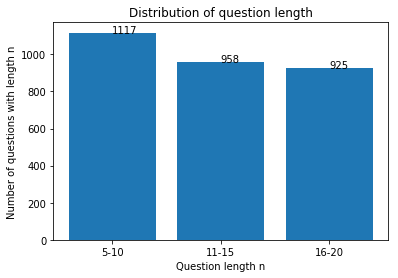

In [0]:
y = np.array([1117, 958, 925])
b = ['5-10', '11-15', '16-20']
plt.bar(b, y)

for xy in zip(b, y):                                       # <--
    plt.annotate('%s' % xy[1], xy=xy, textcoords='data')
plt.xlabel('Question length n')
plt.ylabel("Number of questions with length n")
plt.title("Distribution of question length")
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/sentLen_Dist.png', bbox_inches='tight')
plt.show()

[ 80 219 397 562 549 461 324 209 113  58  20   7   1]


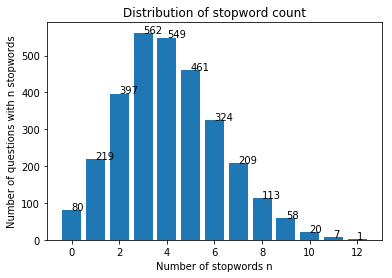

In [0]:
co = []
for d in df['Stopword count']:
  if int(d) > 0:
    co.append(int(d)) # max stopword count is 12

ling_w = []
yi_w = []
er_w = []
san_w = []
si_w = []
wu_w = []
liu_w = []
qi_w = []
ba_w = []
jiu_w = []
shi_w = []
shiyi_w = []
shier_w = []

for d in df['Stopword count']:
  if d == 0:
    ling_w.append(d)
  elif d == 1:
    yi_w.append(d)
  elif d == 2:
    er_w.append(d)
  elif d == 3:
    san_w.append(d)
  elif d == 4:
    si_w.append(d)
  elif d == 5:
    wu_w.append(d)
  elif d == 6:
    liu_w.append(d)
  elif d == 7:
    qi_w.append(d)
  elif d == 8:
    ba_w.append(d)
  elif d == 9:
    jiu_w.append(d)
  elif d == 10:
    shi_w.append(d)
  elif d == 11:
    shiyi_w.append(d)
  elif d > 11:
    shier_w.append(d)

sw = np.array([len(ling_w), len(yi_w), len(er_w), len(san_w), len(si_w), len(wu_w), len(liu_w), len(qi_w), len(ba_w), len(jiu_w), len(shi_w), len(shiyi_w), len(shier_w)])
print(sw)
#plt.hist(sw, bins=10)
r = [0, 1,2, 3, 4, 5, 6, 7 ,8, 9, 10, 11, 12]
plt.bar(r, sw)
for xy in zip(r, sw):                                       # <--
    plt.annotate('%s' % xy[1], xy=xy, textcoords='data')
plt.xlabel('Number of stopwords n')
plt.ylabel("Number of questions with n stopwords")
plt.title("Distribution of stopword count")
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/stopw_Dist.png', bbox_inches='tight')
plt.show()

In [0]:
c_what = 0
for w in df['What questions']:
  if int(w) == 1:
    c_what += 1
print(c_what)
print(len(df['What questions']))

labels = ['Percentage of rows with "1" values', 'Percentage of rows with "0"']
sizes = np.array([730, 2881])
explode = (0.1, 0)
colors = ['#66b3ff','#99ff99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of "what" questions')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

plt.savefig('/content/drive/My Drive/Thesis_feature_sim/what_Dist.png', bbox_inches='tight')
plt.show()

KeyError: ignored

366
3611


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


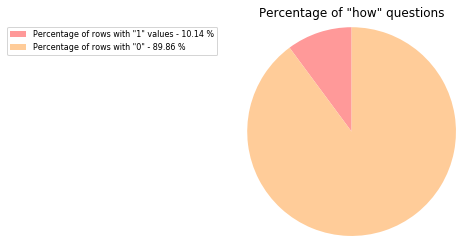

In [0]:
c_how = 0
for w in df['How questions']:
  if int(w) == 1:
    c_how += 1
print(c_how)
print(len(df['How questions']))

labels = ['Percentage of rows with "1" values', 'Percentage of rows with "0"']
sizes = np.array([366, 3245])
explode = (0.1, 0)
colors = ['#ff9999','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of "how" questions')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/how_Dist.png', bbox_inches='tight')
plt.show()

67
3544


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


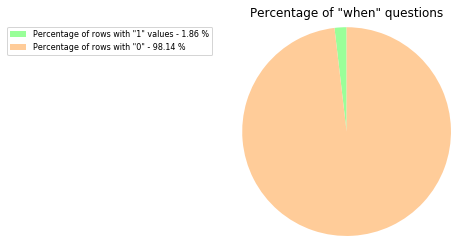

In [0]:
c_when = 0
for w in df['When questions']:
  if int(w) == 1:
    c_when += 1
print(c_when)
print(len(df['When questions'])-ct)

labels = ['Percentage of rows with "1" values', 'Percentage of rows with "0"']
sizes = np.array([67, 3544])
explode = (0.1, 0)
colors = ['#99ff99','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of "when" questions')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/when_Dist.png', bbox_inches='tight')
plt.show()

85
3526


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


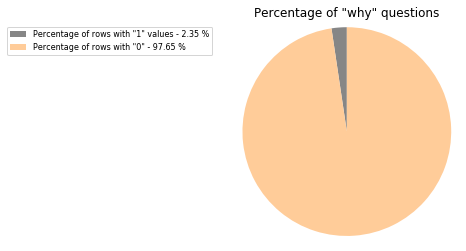

In [0]:
c_why = 0
for w in df['Why questions']:
  if int(w) == 1:
    c_why += 1
print(c_why)
print(len(df['Why questions'])-c_why)

labels = ['Percentage of rows with "1" values', 'Percentage of rows with "0"']
sizes = np.array([85, 3526])
explode = (0.1, 0)
colors = ['#0f0f0f80','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of "why" questions')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/why_Dist.png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


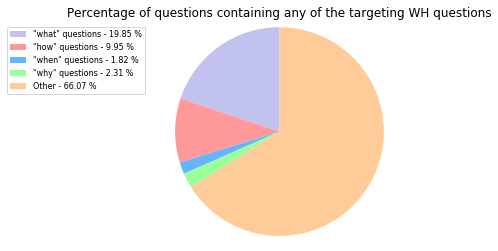

In [0]:
labels = ['"what" questions', '"how" questions', '"when" questions', '"why" questions', 'Other']
sizes = np.array([730, 366, 67, 85, 2430])
explode = (0.1, 0.1, 0.1, 0.1, 0)
colors = ['#c2c2f0','#ff9999','#66b3ff','#99ff99','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of questions containing any of the targeting WH questions')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/WH_Dist.png', bbox_inches='tight')
plt.show()

232
3327


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


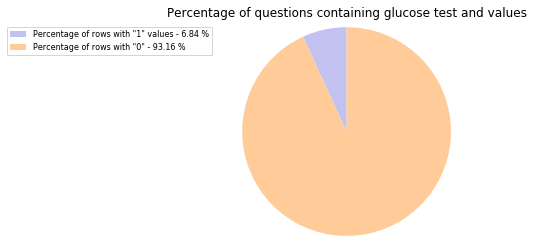

In [0]:
ct = 0
for w in df['Glucose test']:
  if len(w) > 0:
    if int(w) == 1:
      ct += 1
  
print(ct)
print(len(df['Glucose test'])-ct)

labels = ['Percentage of rows with "1" values', 'Percentage of rows with "0"']
sizes = np.array([247, 3364])
explode = (0.1, 0)
colors = ['#c2c2f0','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of questions containing glucose test and values')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/gluTest_Dist.png', bbox_inches='tight')
plt.show()

38
3521


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


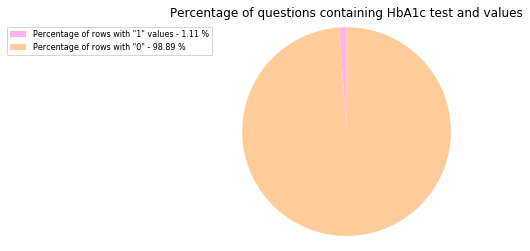

In [0]:
ct = 0
for w in df['HbA1c test']:
  if len(w) > 0:
    if int(w) == 1:
      ct += 1
print(ct)
print(len(df['HbA1c test'])-ct)

labels = ['Percentage of rows with "1" values', 'Percentage of rows with "0"']
sizes = np.array([40, 3571])
explode = (0.1, 0)
colors = ['#ffb3e6','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of questions containing HbA1c test and values')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/a1cTest_Dist.png', bbox_inches='tight')
plt.show()

23
3536


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


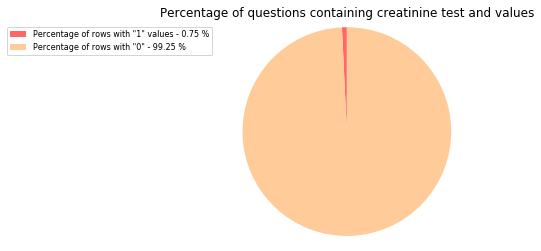

In [0]:
ct = 0
for w in df['Creatinine test']:
  if len(w) > 0:
    if int(w) == 1:
      ct += 1
print(ct)
print(len(df['Creatinine test'])-ct)

labels = ['Percentage of rows with "1" values', 'Percentage of rows with "0"']
sizes = np.array([27, 3584])
explode = (0.1, 0)
colors = ['#ff6666','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of questions containing creatinine test and values')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/creTest_Dist.png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


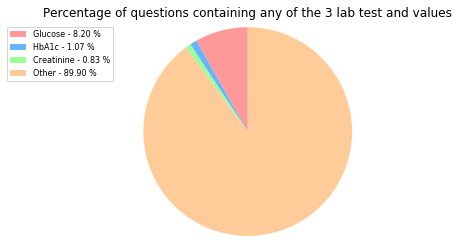

In [0]:
labels = ['Glucose', 'HbA1c', 'Creatinine', 'Other']
sizes = np.array([246, 32, 25, 2697])
explode = (0.1, 0.1, 0.1, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
porcent = 100.*sizes/sizes.sum()
plt.title('Percentage of questions containing any of the 3 lab test and values')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/lab_Dist.png', bbox_inches='tight')
plt.show()

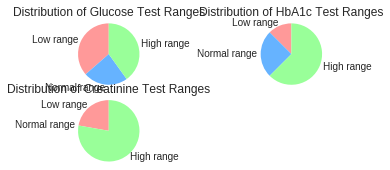

In [0]:
# 3 lab tests: Plot lab range distribution
labels = ['Low range', 'Normal range', 'High range']
glu_sizes = np.array([90, 58, 99])
a1c_sizes = np.array([5, 10, 25])
cre_sizes = np.array([6, 0, 21])
explode = (0, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99']

fig1 = plt.subplot(321)
plt.pie(glu_sizes, colors=colors, startangle=90, radius=1.2)
plt.title('Distribution of Glucose Test Ranges')

fig2 = plt.subplot(322)
plt.pie(a1c_sizes, colors=colors, startangle=90, radius=1.2)
plt.title('Distribution of HbA1c Test Ranges')

fig3 = plt.subplot(323)
plt.pie(cre_sizes, colors=colors, startangle=90, radius=1.2)
plt.title('Distribution of Creatinine Test Ranges')

"""
c1, = ax[0, 0].pie(glu_sizes, colors=colors, startangle=90, radius=1.2)
c2, = ax[0, 1].pie(a1c_sizes, colors=colors, startangle=90, radius=1.2)
c3, = ax[1, 0].pie(cre_sizes, colors=colors, startangle=90, radius=1.2)
# Add title
ax[0, 0].title.set_text('Query Questions - Creatinine')
ax[0, 1].title.set_text('Query Questions - Glucose')
ax[1, 0].title.set_text('Query Questions - HbA1c')
"""
plt.show()

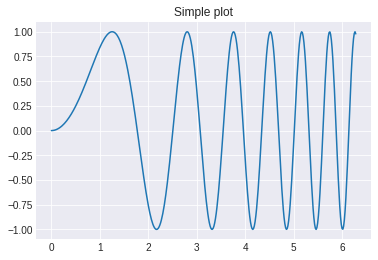

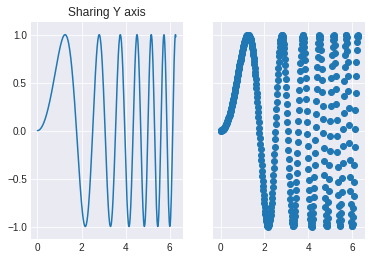

In [0]:
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Creates just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


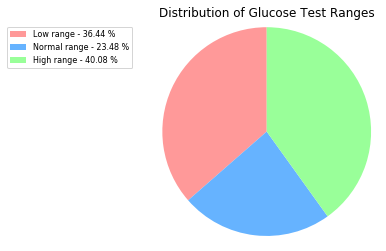

In [0]:
# Glucose: Plot lab value distribution
labels = ['Low range', 'Normal range', 'High range'] # low: 90; normal: 58; high: 99
sizes = np.array([90, 58, 99])
explode = (0, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99']
porcent = 100.*sizes/sizes.sum()
plt.title('Distribution of Glucose Test Ranges')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/gluRange_Dist.png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


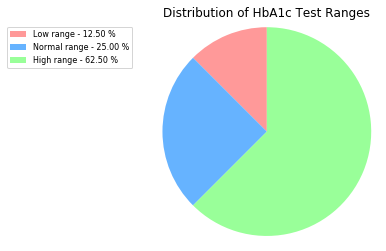

In [0]:
# HbA1c: Plot lab value distribution
labels = ['Low range', 'Normal range', 'High range'] # low: 90; normal: 58; high: 99
sizes = np.array([5, 10, 25])
explode = (0, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99']
porcent = 100.*sizes/sizes.sum()
plt.title('Distribution of HbA1c Test Ranges')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/a1cRange_Dist.png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "left center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


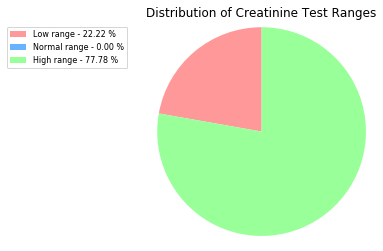

In [0]:
# Creatinine: Plot lab value distribution
labels = ['Low range', 'Normal range', 'High range'] # low: 90; normal: 58; high: 99
sizes = np.array([6, 0, 21])
explode = (0, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99']
porcent = 100.*sizes/sizes.sum()
plt.title('Distribution of Creatinine Test Ranges')
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/creRange_Dist.png', bbox_inches='tight')
plt.show()

In [0]:
# plot feature statistic
pool = pd.read_csv('/content/drive/My Drive/Thesis_feature_sim/length_all_question.csv', header=None, names=['id','question', 'length'])
#sen_len = [d[2] for d in pool] # non-binary draw histogram


#sen_len.pop(0)
pool.head()

,id,question,length
0,3637262,I think I might have diabetes? I'm always thir...,90
1,3550299,Hello to all. Diagnosed just yesterday? Though...,52
2,399703,Can you binge drink if you are diabetic? Empha...,22
3,2351446,I need a sugar daddy ..? My 18th birthday is o...,42
4,3440228,"I am 22 years old, need help with my blood pru...",106


In [0]:
zero2four = []
six2ten = []
eleven2fifteen = []
sixteen2twenty = []
twentyone2twentyfive = []
twentysix2thirty = []
for d in pool['length']:
  if 0 <= int(d) <= 4:
    zero2four.append(d)
  elif 5 <= int(d) <= 10:
    six2ten.append(d)
  elif 11 <= int(d) <= 15:
    eleven2fifteen.append(d)
  elif 16 <= int(d) <= 20:
    sixteen2twenty.append(d)
  elif 21 <= int(d) <= 25:
    twentyone2twentyfive.append(d)
  elif 26 <= int(d) <= 30:
    twentysix2thirty.append(d)

print(len(one2five)) # 1234
print(len(six2ten)) # 5143
print(len(eleven2fifteen)) # 4261
print(len(sixteen2twenty)) # 3731
print(len(twentyone2twentyfive)) # 2914
print(len(twentysix2thirty)) # 2628

1234
5143
4261
3731
2914
2628


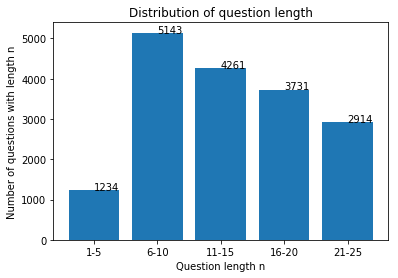

In [0]:
y = np.array([1234, 5143, 4261, 3731, 2914])
b = ['1-5', '6-10', '11-15', '16-20', '21-25']
plt.bar(b, y)

for xy in zip(b, y):                                       # <--
    plt.annotate('%s' % xy[1], xy=xy, textcoords='data')
plt.xlabel('Question length n')
plt.ylabel("Number of questions with length n")
plt.title("Distribution of question length")
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/sentLen_Dist.png', bbox_inches='tight')
plt.show()

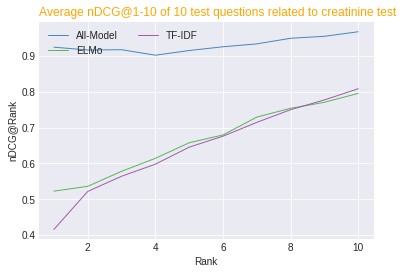

In [0]:
# Average nDCG@1-10 of 10 test questions related to creatinine test
cre_Q1_allModels = [0.925000, 0.917072, 0.917969, 0.902586, 0.915649, 0.926165, 0.934196, 0.949925, 0.955410, 0.968139]
cre_Q1_elmo = [0.522619, 0.536119, 0.578094, 0.614391, 0.657857, 0.679672, 0.729654, 0.754170, 0.770986, 0.795948]
cre_Q1_tfidf = [0.415682, 0.521899, 0.564277, 0.598040, 0.645555, 0.676246, 0.714912, 0.750321, 0.777632, 0.808852]

df=pd.DataFrame({'x': range(1,11), 'All-Model': cre_Q1_allModels, 'ELMo': cre_Q1_elmo, 'TF-IDF': cre_Q1_tfidf})

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
  num+=1
  plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Average nDCG@1-10 of 10 test questions related to creatinine test", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Rank")
plt.ylabel("nDCG@Rank")

# save to google drive
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/nDCG_cre_Avg.png', bbox_inches='tight')

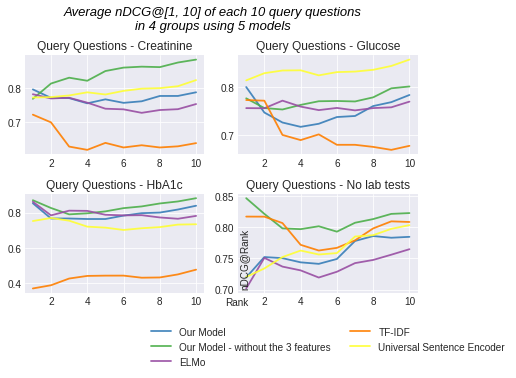

In [0]:
# load data
creatinine_mix_avg_allModel = [0.794953379937338, 0.769969088533675, 
                               0.769296832124983, 0.753841010045046, 
                               0.765622636622611, 0.755251295514347, 
                               0.7598913351319, 0.775577854590593, 
                               0.775641050844679, 0.786427010711178]
creatinine_mix_avg_noFea = [0.767132823772985, 0.812285541296651, 
                            0.82950704833552, 0.820498684207966, 
                            0.849200179575413, 0.859305596921043, 
                            0.86210502475272, 0.860751755808017, 
                            0.874353214338759, 0.882981105535831]
creatinine_mix_avg_elmo = [0.780690309676844, 0.768256034593364, 
                           0.770289717272085, 0.755843719597917, 
                           0.73797121578261, 0.736103850694802, 
                           0.725781231037767, 0.734071920101024, 
                           0.736579643640441, 0.751735224821398]
creatinine_mix_avg_tfidf = [0.720414807399016, 0.697661922541828, 
                            0.626152320533289, 0.616471070130713, 
                            0.637104981808626, 0.62351238333847, 
                            0.630101270147931, 0.623530377019623, 
                            0.626913924368535, 0.636364510266224]
creatinine_mix_avg_use = [0.770960594944163, 0.772210736001005, 
                          0.77709303346527, 0.786358684480185, 
                          0.77991607866991, 0.790620813993624, 
                          0.79712411112263, 0.798641977549843, 
                          0.804416442847421, 0.822420192322515]

glucose_mix_avg_allModel = [0.80049783549754, 0.746830485746791, 
                            0.725808792930525, 0.716690855605608, 
                            0.723163638245667, 0.737337662957133, 
                            0.739543218400766, 0.760456959714024, 
                            0.768684015095423, 0.783794639561831]
glucose_mix_avg_noFea = [0.776724386724918, 0.756264246722322, 
                         0.753218394404383, 0.762881653473417, 
                         0.770579051456874, 0.771127602027509, 
                         0.770122030564589, 0.778795855021091, 
                         0.797793864817231, 0.80169383932258]
glucose_mix_avg_elmo = [0.756118881113096, 0.755785385459032, 0.771820343491215,
                        0.759314292039538, 0.751914674752271, 0.756502701781158, 
                        0.751351037697984, 0.7561836624458, 0.757809298504876, 
                        0.769769891554217]
glucose_mix_avg_tfidf = [0.773129093106799, 0.771737948455842, 0.699640885871674, 
                         0.688794958339333, 0.700841936339009, 0.678887992378515, 
                         0.678870222551705, 0.674499619161611, 0.668235599293801, 
                         0.676726870294395]
glucose_mix_avg_use = [0.814484404474015, 0.829647585967281, 0.835306496252975, 
                       0.835732395129794, 0.825110163665287, 0.831911607886154, 
                       0.833051396328916, 0.836762874381764, 0.844862022277098, 
                       0.858282791191727]

hba1c_mix_avg_allModel = [0.852408052605123, 0.766295628548047, 
                          0.766295628548047, 0.763389394337297, 
                          0.763389394337297, 0.782649096588222, 
                          0.796333431907597, 0.799818596579041, 
                          0.817084075543085, 0.838448648527125]
hba1c_mix_avg_noFea = [0.869561534399384, 0.825634938558308, 0.789751168532294, 
                       0.795613616466017, 0.806538431228874, 0.824832746754655, 
                       0.834511750275109, 0.851252719565475, 0.862658303480434, 
                       0.881057618994575]
hba1c_mix_avg_elmo = [0.860755630978485, 0.784074148140436, 0.810577186012507, 
                      0.809340276441324, 0.78736020238753, 0.783933745233013, 
                      0.785009960071382, 0.772169677899455, 0.764757824853122, 
                      0.781015781988081]
hba1c_mix_avg_tfidf = [0.370924660259519, 0.389059071342685, 0.427028092787579, 
                       0.441827330181072, 0.443399330199503, 0.443519132287146, 
                       0.431720893041993, 0.433113829872693, 0.450436672988184, 
                       0.477225327056578]
hba1c_mix_avg_use = [0.752037880813201, 0.769025583113848, 0.753908523770241, 
                     0.720333151185792, 0.714682877487432, 0.701496037212064, 
                     0.711194681692379, 0.717731593995078, 0.731824859473729, 
                     0.733717642759216]

noLab_mix_avg_allModel = [0.719315818284189, 0.751949581351347, 
                          0.750191171161972, 0.743478389934929, 0.741049907189417, 
                          0.748888741246489, 0.7776470089169, 0.785538444133904, 
                          0.782830564695472, 0.784293064186076]
noLab_mix_avg_noFea = [0.846128899851864, 0.821044421532444, 0.797788655627365, 
                       0.796580250284443, 0.801215146572095, 0.792564400304146, 
                       0.806826729259403, 0.812709564193135, 0.821006790044688, 
                       0.822311099204924]
noLab_mix_avg_elmo = [0.701676929389467, 0.75065570001668, 0.736648622595587, 
                      0.730616003968482, 0.71915872530556, 0.728417242600488, 
                      0.742237931217528, 0.747308780170259, 0.755715018693462, 
                      0.764492835703492]
noLab_mix_avg_tfidf = [0.816684455394919, 0.816566535205667, 0.806289029923412, 
                       0.771499997366876, 0.762388144121497, 0.766657623798317, 
                       0.778646826858854, 0.797767093121705, 0.809066220936779, 
                       0.808055528051329]
noLab_mix_avg_use = [0.720151888359037, 0.73368816895702, 0.751947650077058, 
                     0.762317965286301, 0.756025718357112, 0.758272702382895, 
                     0.784822980208218, 0.786950422997107, 0.797104698044411, 
                     0.803007484382218]

df_cre = pd.DataFrame({'x': range(1,11), 'Our Model': creatinine_mix_avg_allModel, 
                 'Our Model - without the 3 features':creatinine_mix_avg_noFea, 
                 'ELMo': creatinine_mix_avg_elmo, 
                 'TF-IDF': creatinine_mix_avg_tfidf, 
                 'Universal Sentence Encoder': creatinine_mix_avg_use})
df_glu = pd.DataFrame({'x': range(1,11), 'Our Model': glucose_mix_avg_allModel, 
                 'Our Model - without the 3 features':glucose_mix_avg_noFea, 
                 'ELMo': glucose_mix_avg_elmo, 
                 'TF-IDF': glucose_mix_avg_tfidf, 
                 'Universal Sentence Encoder': glucose_mix_avg_use})
df_a1c = pd.DataFrame({'x': range(1,11), 'Our Model': hba1c_mix_avg_allModel, 
                 'Our Model - without the 3 features':hba1c_mix_avg_noFea, 
                 'ELMo': hba1c_mix_avg_elmo, 
                 'TF-IDF': hba1c_mix_avg_tfidf, 
                 'Universal Sentence Encoder': hba1c_mix_avg_use})
df_noLab = pd.DataFrame({'x': range(1,11), 'Our Model': noLab_mix_avg_allModel, 
                 'Our Model - without the 3 features':noLab_mix_avg_noFea, 
                 'ELMo': noLab_mix_avg_elmo, 
                 'TF-IDF': noLab_mix_avg_tfidf, 
                 'Universal Sentence Encoder': noLab_mix_avg_use})
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

# arrange as multiple subplot
fig, ax = plt.subplots(2, 2)

# multiple line plot
num=0
for column in df_cre.drop('x', axis=1):
  num+=1
  c1, = ax[0, 0].plot(df_cre['x'], df_cre[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  c2, = ax[0, 1].plot(df_glu['x'], df_glu[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  c3, = ax[1, 0].plot(df_a1c['x'], df_a1c[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  c4, = ax[1, 1].plot(df_noLab['x'], df_noLab[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  # Add title
  ax[0, 0].title.set_text('Query Questions - Creatinine')
  ax[0, 1].title.set_text('Query Questions - Glucose')
  ax[1, 0].title.set_text('Query Questions - HbA1c')
  ax[1, 1].title.set_text('Query Questions - No lab tests')
  # prevent overlapping of subplot titles and labels
  plt.tight_layout()

# Add legend
#plt.legend(loc='upper center', ncol=2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=2)
 
# Add titles
plt.suptitle("Average nDCG@[1, 10] of each 10 query questions\nin 4 groups using 5 models", fontsize=13, fontweight=0, color='black', style='italic', y=1.08)
# Axis title
plt.text(0.48, 0.68, 'Rank', ha='center', va='center')
plt.text(0.9, 0.75, 'nDCG@Rank', ha='center', va='center', rotation='vertical')

# save image
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/nDCG_modelComparison.png', bbox_inches='tight')

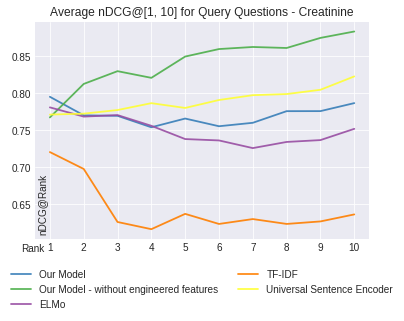

In [0]:
creatinine_mix_avg_allModel = [0.794953379937338, 0.769969088533675, 
                               0.769296832124983, 0.753841010045046, 
                               0.765622636622611, 0.755251295514347, 
                               0.7598913351319, 0.775577854590593, 
                               0.775641050844679, 0.786427010711178]
creatinine_mix_avg_noFea = [0.767132823772985, 0.812285541296651, 
                            0.82950704833552, 0.820498684207966, 
                            0.849200179575413, 0.859305596921043, 
                            0.86210502475272, 0.860751755808017, 
                            0.874353214338759, 0.882981105535831]
creatinine_mix_avg_elmo = [0.780690309676844, 0.768256034593364, 
                           0.770289717272085, 0.755843719597917, 
                           0.73797121578261, 0.736103850694802, 
                           0.725781231037767, 0.734071920101024, 
                           0.736579643640441, 0.751735224821398]
creatinine_mix_avg_tfidf = [0.720414807399016, 0.697661922541828, 
                            0.626152320533289, 0.616471070130713, 
                            0.637104981808626, 0.62351238333847, 
                            0.630101270147931, 0.623530377019623, 
                            0.626913924368535, 0.636364510266224]
creatinine_mix_avg_use = [0.770960594944163, 0.772210736001005, 
                          0.77709303346527, 0.786358684480185, 
                          0.77991607866991, 0.790620813993624, 
                          0.79712411112263, 0.798641977549843, 
                          0.804416442847421, 0.822420192322515]

df_cre = pd.DataFrame({'x': range(1,11), 'Our Model': creatinine_mix_avg_allModel, 
                 'Our Model - without engineered features':creatinine_mix_avg_noFea, 
                 'ELMo': creatinine_mix_avg_elmo, 
                 'TF-IDF': creatinine_mix_avg_tfidf, 
                 'Universal Sentence Encoder': creatinine_mix_avg_use})

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

num=0
for column in df_cre.drop('x', axis=1):
  num+=1
  plt.plot(df_cre['x'], df_cre[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  plt.xticks(np.arange(1, 11, 1.0))
  plt.title('Average nDCG@[1, 10] for Query Questions - Creatinine')

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)


# Axis title
plt.text(0.48, 0.59, 'Rank', ha='center', va='center')
plt.text(0.79, 0.65, 'nDCG@Rank', ha='center', va='center', rotation='vertical')

# save image
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/nDCG_cre_modelComparison.png', bbox_inches='tight')

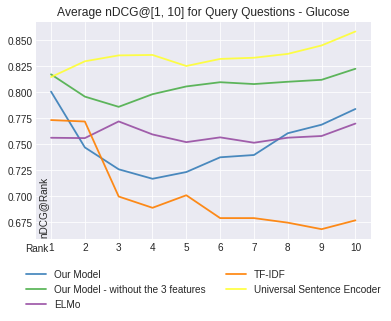

In [0]:
glucose_mix_avg_allModel = [0.80049783549754, 0.746830485746791, 
                            0.725808792930525, 0.716690855605608, 
                            0.723163638245667, 0.737337662957133, 
                            0.739543218400766, 0.760456959714024, 
                            0.768684015095423, 0.783794639561831]
glucose_mix_avg_noFea = [0.817084027085385, 0.795681560108926, 0.785861138392768, 
                         0.798008204813865, 0.805464136317566, 0.80952803740938, 
                         0.807746162555632, 0.809952302152832, 0.811832511465772, 0.822442286918849]
glucose_mix_avg_elmo = [0.756118881113096, 0.755785385459032, 0.771820343491215,
                        0.759314292039538, 0.751914674752271, 0.756502701781158, 
                        0.751351037697984, 0.7561836624458, 0.757809298504876, 
                        0.769769891554217]
glucose_mix_avg_tfidf = [0.773129093106799, 0.771737948455842, 0.699640885871674, 
                         0.688794958339333, 0.700841936339009, 0.678887992378515, 
                         0.678870222551705, 0.674499619161611, 0.668235599293801, 
                         0.676726870294395]
glucose_mix_avg_use = [0.814484404474015, 0.829647585967281, 0.835306496252975, 
                       0.835732395129794, 0.825110163665287, 0.831911607886154, 
                       0.833051396328916, 0.836762874381764, 0.844862022277098, 
                       0.858282791191727]

df_glu = pd.DataFrame({'x': range(1,11), 'Our Model': glucose_mix_avg_allModel, 
                 'Our Model - without the 3 features':glucose_mix_avg_noFea, 
                 'ELMo': glucose_mix_avg_elmo, 
                 'TF-IDF': glucose_mix_avg_tfidf, 
                 'Universal Sentence Encoder': glucose_mix_avg_use})

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

num=0
for column in df_glu.drop('x', axis=1):
  num+=1
  plt.plot(df_glu['x'], df_glu[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  plt.xticks(np.arange(1, 11, 1.0))
  plt.title('Average nDCG@[1, 10] for Query Questions - Glucose')

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)


# Axis title
plt.text(0.59, 0.65, 'Rank', ha='center', va='center')
plt.text(0.79, 0.69, 'nDCG@Rank', ha='center', va='center', rotation='vertical')

# save image
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/nDCG_glu_modelComparison.png', bbox_inches='tight')

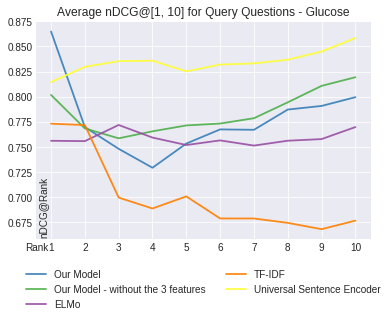

In [0]:
glucose_mix_avg_allModel = [0.864783549783255, 0.76974491237172, 0.748113410900336, 
                            0.729316121932804, 0.753376454648831, 0.767434324279969, 
                            0.76705583142299, 0.787173806717131, 0.790764731056909, 
                            0.799483053507311]
glucose_mix_avg_noFea = [0.801724386724918, 0.768369153147838, 0.758572357246713, 
                         0.765538264247665, 0.771380669426063, 0.77326980220521, 
                         0.778559637761932, 0.794366578834945, 0.810727045457886, 
                         0.81932561256736]
glucose_mix_avg_elmo = [0.756118881113096, 0.755785385459032, 0.771820343491215,
                        0.759314292039538, 0.751914674752271, 0.756502701781158, 
                        0.751351037697984, 0.7561836624458, 0.757809298504876, 
                        0.769769891554217]
glucose_mix_avg_tfidf = [0.773129093106799, 0.771737948455842, 0.699640885871674, 
                         0.688794958339333, 0.700841936339009, 0.678887992378515, 
                         0.678870222551705, 0.674499619161611, 0.668235599293801, 
                         0.676726870294395]
glucose_mix_avg_use = [0.814484404474015, 0.829647585967281, 0.835306496252975, 
                       0.835732395129794, 0.825110163665287, 0.831911607886154, 
                       0.833051396328916, 0.836762874381764, 0.844862022277098, 
                       0.858282791191727]

df_glu = pd.DataFrame({'x': range(1,11), 'Our Model': glucose_mix_avg_allModel, 
                 'Our Model - without the 3 features':glucose_mix_avg_noFea, 
                 'ELMo': glucose_mix_avg_elmo, 
                 'TF-IDF': glucose_mix_avg_tfidf, 
                 'Universal Sentence Encoder': glucose_mix_avg_use})

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

num=0
for column in df_glu.drop('x', axis=1):
  num+=1
  plt.plot(df_glu['x'], df_glu[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  plt.xticks(np.arange(1, 11, 1.0))
  plt.title('Average nDCG@[1, 10] for Query Questions - Glucose')

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)


# Axis title
plt.text(0.59, 0.65, 'Rank', ha='center', va='center')
plt.text(0.79, 0.69, 'nDCG@Rank', ha='center', va='center', rotation='vertical')

# save image
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/nDCG_glu_modelComparison_b.png', bbox_inches='tight')

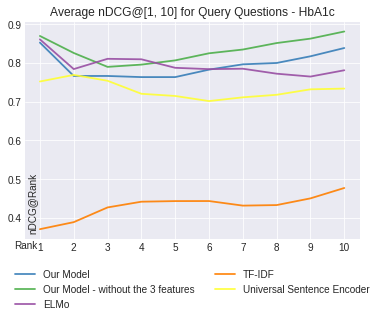

In [0]:
hba1c_mix_avg_allModel = [0.852408052605123, 0.766295628548047, 
                          0.766295628548047, 0.763389394337297, 
                          0.763389394337297, 0.782649096588222, 
                          0.796333431907597, 0.799818596579041, 
                          0.817084075543085, 0.838448648527125]
hba1c_mix_avg_noFea = [0.869561534399384, 0.825634938558308, 0.789751168532294, 
                       0.795613616466017, 0.806538431228874, 0.824832746754655, 
                       0.834511750275109, 0.851252719565475, 0.862658303480434, 
                       0.881057618994575]
hba1c_mix_avg_elmo = [0.860755630978485, 0.784074148140436, 0.810577186012507, 
                      0.809340276441324, 0.78736020238753, 0.783933745233013, 
                      0.785009960071382, 0.772169677899455, 0.764757824853122, 
                      0.781015781988081]
hba1c_mix_avg_tfidf = [0.370924660259519, 0.389059071342685, 0.427028092787579, 
                       0.441827330181072, 0.443399330199503, 0.443519132287146, 
                       0.431720893041993, 0.433113829872693, 0.450436672988184, 
                       0.477225327056578]
hba1c_mix_avg_use = [0.752037880813201, 0.769025583113848, 0.753908523770241, 
                     0.720333151185792, 0.714682877487432, 0.701496037212064, 
                     0.711194681692379, 0.717731593995078, 0.731824859473729, 
                     0.733717642759216]

df_a1c = pd.DataFrame({'x': range(1,11), 'Our Model': hba1c_mix_avg_allModel, 
                 'Our Model - without the 3 features':hba1c_mix_avg_noFea, 
                 'ELMo': hba1c_mix_avg_elmo, 
                 'TF-IDF': hba1c_mix_avg_tfidf, 
                 'Universal Sentence Encoder': hba1c_mix_avg_use})

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

num=0
for column in df_a1c.drop('x', axis=1):
  num+=1
  plt.plot(df_a1c['x'], df_a1c[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  plt.xticks(np.arange(1, 11, 1.0))
  plt.title('Average nDCG@[1, 10] for Query Questions - HbA1c')

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)


# Axis title
plt.text(0.59, 0.33, 'Rank', ha='center', va='center')
plt.text(0.79, 0.44, 'nDCG@Rank', ha='center', va='center', rotation='vertical')

# save image
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/nDCG_a1c_modelComparison.png', bbox_inches='tight')

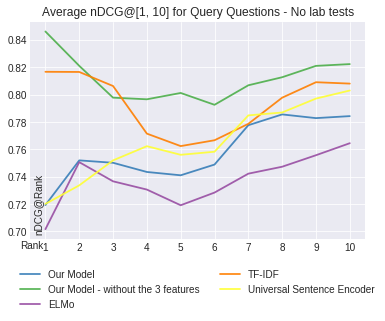

In [0]:
noLab_mix_avg_allModel = [0.719315818284189, 0.751949581351347, 
                          0.750191171161972, 0.743478389934929, 0.741049907189417, 
                          0.748888741246489, 0.7776470089169, 0.785538444133904, 
                          0.782830564695472, 0.784293064186076]
noLab_mix_avg_noFea = [0.846128899851864, 0.821044421532444, 0.797788655627365, 
                       0.796580250284443, 0.801215146572095, 0.792564400304146, 
                       0.806826729259403, 0.812709564193135, 0.821006790044688, 
                       0.822311099204924]
noLab_mix_avg_elmo = [0.701676929389467, 0.75065570001668, 0.736648622595587, 
                      0.730616003968482, 0.71915872530556, 0.728417242600488, 
                      0.742237931217528, 0.747308780170259, 0.755715018693462, 
                      0.764492835703492]
noLab_mix_avg_tfidf = [0.816684455394919, 0.816566535205667, 0.806289029923412, 
                       0.771499997366876, 0.762388144121497, 0.766657623798317, 
                       0.778646826858854, 0.797767093121705, 0.809066220936779, 
                       0.808055528051329]
noLab_mix_avg_use = [0.720151888359037, 0.73368816895702, 0.751947650077058, 
                     0.762317965286301, 0.756025718357112, 0.758272702382895, 
                     0.784822980208218, 0.786950422997107, 0.797104698044411, 
                     0.803007484382218]

df_noLab = pd.DataFrame({'x': range(1,11), 'Our Model': noLab_mix_avg_allModel, 
                 'Our Model - without the 3 features':noLab_mix_avg_noFea, 
                 'ELMo': noLab_mix_avg_elmo, 
                 'TF-IDF': noLab_mix_avg_tfidf, 
                 'Universal Sentence Encoder': noLab_mix_avg_use})

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

num=0
for column in df_noLab.drop('x', axis=1):
  num+=1
  plt.plot(df_noLab['x'], df_noLab[column], marker='', color=palette(num), linewidth=1.8, alpha=0.9, label=column)
  plt.xticks(np.arange(1, 11, 1.0))
  plt.title('Average nDCG@[1, 10] for Query Questions - No lab tests')

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)


# Axis title
plt.text(0.59, 0.69, 'Rank', ha='center', va='center')
plt.text(0.788, 0.72, 'nDCG@Rank', ha='center', va='center', rotation='vertical')

# save image
plt.savefig('/content/drive/My Drive/Thesis_feature_sim/img/nDCG_noLab_modelComparison.png', bbox_inches='tight')